# NLP workshop

## Input data

#### List of titles of best 100 films ever

In [1]:
titles = open('data/title_list.txt').read().split('\n')[0:100]

titles[:15]

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca',
 "One Flew Over the Cuckoo's Nest",
 'Gone with the Wind',
 'Citizen Kane',
 'The Wizard of Oz',
 'Titanic',
 'Lawrence of Arabia',
 'The Godfather: Part II',
 'Psycho',
 'Sunset Blvd.',
 'Vertigo']

#### List of synopses of best 100 films ever

In [2]:
synopses = open('data/synopses_list.txt').read().split('\n BREAKS HERE')[0:100]

synopses[:5]

[' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson

## Text cleaning

In [3]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

nlp = spacy.load('en')

# English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [4]:
import re

def spacy_tokenizer(sentence):

    tokens = parser(sentence)
    
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [5]:
spacy_tokenizer(synopses[0])[:15]

['plot',
 'edit',
 'edit',
 'edit',
 'day',
 'daughter',
 'wed',
 'vito',
 'corleone',
 'hear',
 'request',
 'role',
 'godfather',
 'don',
 'new']

## TD-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=0.15, tokenizer=spacy_tokenizer)

tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

tfidf_matrix.shape

(100, 283)

In [7]:
tfidf_matrix

<100x283 sparse matrix of type '<class 'numpy.float64'>'
	with 8253 stored elements in Compressed Sparse Row format>

In [8]:
terms = tfidf_vectorizer.get_feature_names()

terms[:15]

['able',
 'accept',
 'act',
 'admit',
 'affair',
 'agree',
 'air',
 'allow',
 'american',
 'apartment',
 'appear',
 'approach',
 'arm',
 'army',
 'arrange']

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

dist.shape

(100, 100)

## Clustering

### UMAP

In [10]:
import warnings
from umap import UMAP

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    umap = UMAP(n_neighbors=5, random_state=42)
    embedding = umap.fit_transform(dist)

embedding[:5]

array([[ 2.011517  ,  4.7797055 ],
       [-0.34197658,  4.049107  ],
       [-3.666917  ,  1.15052   ],
       [ 2.4180021 ,  2.5457795 ],
       [-1.2551954 ,  3.299562  ]], dtype=float32)

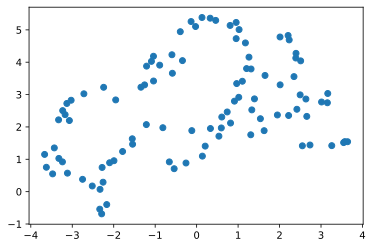

In [11]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')

plt.scatter(embedding[:,0], embedding[:,1]);

### HDBSCAN

In [12]:
import numpy as np
from hdbscan import HDBSCAN
    
hdbscan = HDBSCAN(min_cluster_size=5)

clustering = hdbscan.fit_predict(embedding)

np.unique(clustering)

/home/ubuntu/.venvs/ironhack_env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/ubuntu/.venvs/ironhack_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


array([-1,  0,  1,  2,  3])

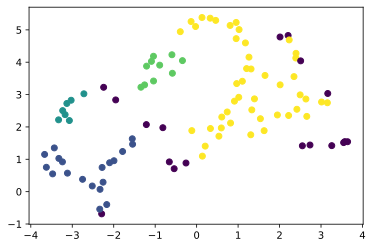

In [13]:
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);

In [14]:
import pandas as pd

def get_titles_from_cluster(cluster):
    return pd.Series(titles)[clustering==cluster]

titles_cluster = get_titles_from_cluster(0)
titles_cluster

2                                      Schindler's List
10                                   Lawrence of Arabia
19                                            Star Wars
24                         The Bridge on the River Kwai
29    Dr. Strangelove or: How I Learned to Stop Worr...
31                                       Apocalypse Now
33        The Lord of the Rings: The Return of the King
34                                            Gladiator
36                                  Saving Private Ryan
38                              Raiders of the Lost Ark
48                                               Patton
50                                           Braveheart
55                                              Platoon
57                                   Dances with Wolves
58                                          The Pianist
62                       All Quiet on the Western Front
87                                    The African Queen
88                                           Sta

In [15]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,able,accept,act,admit,affair,agree,air,allow,american,apartment,...,window,witness,woman,work,world,wound,wrong,year,york,young
0,0.0,0.187468,0.067164,0.000000,0.000000,0.046947,0.00000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.089432,0.131826,0.046371
1,0.0,0.000000,0.000000,0.074005,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.096533,0.058522,0.0,0.072427,0.090805,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.050046,0.00000,0.121030,0.000000,0.0,...,0.0,0.066614,0.054782,0.000000,0.153604,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.140499,0.000000,0.07025,0.000000,0.090343,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.043099,0.190587,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.053877,0.00000,0.065147,0.071714,0.0,...,0.0,0.000000,0.000000,0.054554,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [16]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

get_df_from_cluster(0)

,able,accept,act,admit,affair,agree,air,allow,american,apartment,...,window,witness,woman,work,world,wound,wrong,year,york,young
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.050046,0.000000,0.121030,0.000000,0.000000,...,0.000000,0.066614,0.054782,0.000000,0.153604,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065031,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.149953,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.056097,0.046133,0.170697,0.077612,0.232401,0.000000,0.000000,0.000000,0.000000
29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.296593,0.084001,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.035171,0.042644,0.000000,0.000000,0.033084,0.000000,0.000000
31,0.000000,0.000000,0.000000,0.000000,0.000000,0.112764,0.087534,0.068176,0.075048,0.000000,...,0.000000,0.000000,0.000000,0.057090,0.000000,0.155454,0.000000,0.000000,0.000000,0.000000
33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.049424,0.000000,0.000000,0.062244,0.000000,0.043005,0.000000,0.000000
34,0.053333,0.000000,0.000000,0.054495,0.000000,0.000000,0.000000,0.042444,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034670
36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062533,0.309761,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142587,0.000000,0.000000,0.000000,0.000000
38,0.000000,0.000000,0.000000,0.000000,0.092846,0.000000,0.092846,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090866,0.000000,0.000000,0.000000


In [17]:
get_df_from_cluster(0).T.head()

,2,10,19,24,29,31,33,34,36,38,48,50,55,57,58,62,87,88,89
able,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053333,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.079178,0.0,0.000000,0.0,0.0
accept,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.068863,0.0,0.067462,0.000000,0.0,0.000000,0.0,0.0
act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.072509,0.000000,0.0,0.000000,0.0,0.0
admit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054495,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.076565,0.0,0.0
affair,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.092846,0.0,0.080320,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [18]:
top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

army       2.733560
war        2.557228
soldier    2.504174
kill       2.029850
general    1.943894
dtype: float64

In [19]:
titles_cluster

2                                      Schindler's List
10                                   Lawrence of Arabia
19                                            Star Wars
24                         The Bridge on the River Kwai
29    Dr. Strangelove or: How I Learned to Stop Worr...
31                                       Apocalypse Now
33        The Lord of the Rings: The Return of the King
34                                            Gladiator
36                                  Saving Private Ryan
38                              Raiders of the Lost Ark
48                                               Patton
50                                           Braveheart
55                                              Platoon
57                                   Dances with Wolves
58                                          The Pianist
62                       All Quiet on the Western Front
87                                    The African Queen
88                                           Sta